# bert for question answering experiments

In [2]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to('cuda')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# model_checkpoint = "distilbert-base-cased-distilled-squad"
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)#.to('cuda')

# model_base = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to('cuda')
# tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')

/home/pgajo/working/food/food-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
question = '''What is Machine Learning?'''

paragraph = ''' Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to progressively improve their performance 
                on a specific task. Machine learning algorithms build a mathematical model of sample data, known as "training data", in order to make predictions or 
                decisions without being explicitly programmed to perform the task. Machine learning algorithms are used in the applications of email filtering, detection 
                of network intruders, and computer vision, where it is infeasible to develop an algorithm of specific instructions for performing the task. Machine learning 
                is closely related to computational statistics, which focuses on making predictions using computers. The study of mathematical optimization delivers methods, 
                theory and application domains to the field of machine learning. Data mining is a field of study within machine learning, and focuses on exploratory 
                data analysis through unsupervised learning.In its application across business problems, machine learning is also referred to as predictive analytics. '''
            
inputs = tokenizer(question, paragraph, return_tensors = 'pt', padding = 'max_length')
print('inputs', inputs)

input_ids = inputs['input_ids']  #Token embeddings

sentence_embedding = inputs['token_type_ids']  #Segment embeddings
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0)) #input tokens
print(tokens)
print(len(sentence_embedding[0]))
seq = sentence_embedding[0].tolist()
print(seq)
sequence_ids = []
for i,el in enumerate(seq):
    buffer = None
    if tokens[i] not in ['[CLS]', '[SEP]']:
        buffer = el
    sequence_ids.append(buffer)
print('sequence_ids', sequence_ids)

inputs {'input_ids': tensor([[  101,  2054,  2003,  3698,  4083,  1029,   102,  3698,  4083,  1006,
         19875,  1007,  2003,  1996,  4045,  2817,  1997, 13792,  1998,  7778,
          4275,  2008,  3274,  3001,  2224,  2000, 20519,  5335,  2037,  2836,
          2006,  1037,  3563,  4708,  1012,  3698,  4083, 13792,  3857,  1037,
          8045,  2944,  1997,  7099,  2951,  1010,  2124,  2004,  1000,  2731,
          2951,  1000,  1010,  1999,  2344,  2000,  2191, 20932,  2030,  6567,
          2302,  2108, 12045, 16984,  2000,  4685,  1996,  4708,  1012,  3698,
          4083, 13792,  2024,  2109,  1999,  1996,  5097,  1997, 10373, 22910,
          1010, 10788,  1997,  2897, 22841,  2015,  1010,  1998,  3274,  4432,
          1010,  2073,  2009,  2003,  1999,  7959, 21369,  3468,  2000,  4503,
          2019,  9896,  1997,  3563,  8128,  2005,  4488,  1996,  4708,  1012,
          3698,  4083,  2003,  4876,  3141,  2000, 15078,  6747,  1010,  2029,
          7679,  2006,  2437, 2

In [4]:
outputs = model(
    input_ids = input_ids.to('cuda'),
    token_type_ids = sentence_embedding.to('cuda'),
    output_hidden_states = True,
    )
# outputs_base = model_base(
#     input_ids=torch.tensor([inputs]).to('cuda'),
#     token_type_ids=torch.tensor([sentence_embedding]).to('cuda'),
    # )

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [5]:
# Access weights and bias of the 'qa_outputs' layer
qa_outputs_weights = model.qa_outputs.weight.data
# print('qa_outputs_weights', qa_outputs_weights)
print('qa_outputs_weights.shape', qa_outputs_weights.shape)
qa_outputs_bias = model.qa_outputs.bias.data
# print('qa_outputs_bias', qa_outputs_bias)
print('qa_outputs_bias.shape', qa_outputs_bias.shape)
# print(outputs)
# print(outputs[0].shape)
print('outputs.hidden_states[-1].squeeze(0).shape', outputs.hidden_states[-1].squeeze(0).shape)
print('qa_outputs_weights.T.shape', qa_outputs_weights.T.shape)
output_raw = torch.matmul(outputs.hidden_states[-1].squeeze(0), qa_outputs_weights.T) + qa_outputs_bias
print('output_raw.shape', output_raw.shape)
print('output_raw', output_raw[:2])

qa_outputs_weights.shape torch.Size([2, 1024])
qa_outputs_bias.shape torch.Size([2])
outputs.hidden_states[-1].squeeze(0).shape torch.Size([512, 1024])
qa_outputs_weights.T.shape torch.Size([1024, 2])
output_raw.shape torch.Size([512, 2])
output_raw tensor([[-0.4483,  0.7284],
        [-4.4956, -4.5839]], device='cuda:0', grad_fn=<SliceBackward0>)


In [33]:
id(outputs[0]) == id(outputs.start_logits)

True

In [22]:
start_logits = outputs.start_logits
print(start_logits[0][:10])
end_logits = outputs.end_logits
print(end_logits[0][:10])
print(start_logits.shape, end_logits.shape)

tensor([-0.4483, -4.4956, -6.5006, -7.5513, -8.5267, -8.1034, -3.1082,  0.1175,
        -3.8746, -1.9032], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.7284, -4.5839, -5.7382, -7.7743, -6.7764, -6.0796, -3.0887, -5.1192,
        -4.1313, -7.1177], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([1, 512]) torch.Size([1, 512])


In [23]:
print(sequence_ids)
mask = [el!=1 for el in sequence_ids]
mask[0] = False
print(mask)
start_logits[0][mask] = -10000
end_logits[0][mask] = -10000

[None, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [37]:
start_index = torch.argmax(torch.nn.functional.softmax(start_logits, dim = 1))
print(start_index)

end_index = torch.argmax(torch.nn.functional.softmax(end_logits, dim = 1))
print(end_index)

answer = ' '.join(tokens[start_index:end_index+1])

print(answer)

tensor(13, device='cuda:0')
tensor(33, device='cuda:0')
the scientific study of algorithms and statistical models that computer systems use to progressively improve their performance on a specific task


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensor data to numpy array for easy handling
tensor_start_data = [el for el in outputs.start_logits.detach().cpu().numpy().flatten() if el > -10000]
print(tensor_start_data)
tensor_end_data = [el for el in outputs.end_logits.detach().cpu().numpy().flatten() if el > -10000]
print(tensor_end_data)

# Create an array of indices for each element in the tensor
indices_start_index = np.arange(len(tensor_start_data))
indices_end_index = np.arange(len(tensor_end_data))

[-0.4482835, 0.11746558, -3.8745842, -1.903182, 0.048312113, -5.6943264, 3.0486987, 5.559827, 5.364306, 0.957983, 0.04750908, 5.0305543, -2.0795443, 2.1853933, -0.40778458, -2.309554, 2.4451754, -1.2702531, -1.1580856, -0.16112609, 0.7301337, -0.21324502, -3.2381513, -2.0957325, -3.3846526, -2.960046, -2.7495656, -1.8727522, -0.4485955, -1.1118174, -5.1024356, -0.7349992, -2.4622724, -4.14996, -2.5342867, -4.687025, -7.0755405, -3.4693742, -4.376023, -7.541613, -5.328036, -7.646465, -3.909869, -1.9585654, -5.750306, -7.260873, -7.566951, -4.56269, -5.0652103, -3.5143406, -4.18295, -3.4134622, -8.543377, -5.251555, -6.2018633, -8.275155, -6.707437, -6.315307, -8.720025, -8.084398, -7.297001, -6.963512, -8.360485, -2.4786859, -6.0714903, -3.075008, -7.3646865, -4.761561, -7.124476, -6.3881598, -4.190819, -8.121894, -3.9721756, -6.170805, -8.502367, -4.6706886, -8.441393, -6.601609, -7.5428677, -8.190419, -8.955906, -8.051716, -4.7228575, -5.827192, -7.696338, -5.062555, -4.8338323, -7.85

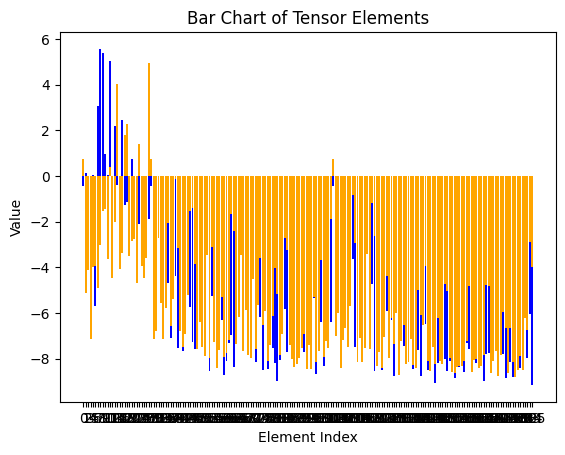

In [56]:
# Visualize each element of the tensor in a bar chart
plt.bar(indices_start_index, tensor_start_data, color='blue')
plt.bar(indices_start_index, tensor_end_data, color='orange')
plt.title("Bar Chart of Tensor Elements")
plt.xlabel("Element Index")
plt.ylabel("Value")
plt.xticks(indices_start_index)
plt.show()